# Block Move in Minimum Time

Now let's try solving Block Move with something a little different.

Suppose now we want to complete our block move in the minimum time possible.

Of course, our control vector $u(t)$ before was unbounded, so if we simply remove the fixed $t_{final} = 1$ and tell it to move in minimum time, that problem is unbounded - it can achieve that infinitely fast.

So, let's also bound our input control vector $u(t)$ from -1 to 1.

First, we set up our problem as before:

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np

n_timesteps = 100
mass_block = 1

opti = asb.Opti()

Now, we do something interesting.

Instead of having `time` be a linearly-spaced vector from $t=0$ to $t=1$, we now have it be a linearly-spaced vector between $t=0$ and $t=t_{final}$, where $t_{final}$ is an optimization variable:

In [2]:
time_final = opti.variable(init_guess=1, lower_bound=0)

time = np.linspace(0, time_final, n_timesteps)

We then continue setting up our problem as before:

In [3]:
position = opti.variable(
    init_guess=np.linspace(0, 1, n_timesteps)
)

velocity = opti.derivative_of(
    position,
    with_respect_to=time,
    derivative_init_guess=1,
)

force = opti.variable(
    init_guess=np.linspace(1, -1, n_timesteps),
    n_vars=n_timesteps,
    lower_bound=-1,  # The force is now bounded
    upper_bound=1  # The force is now bounded
)

opti.constrain_derivative(
    variable=velocity,
    with_respect_to=time,
    derivative=force / mass_block,
)

### Boundary conditions
opti.subject_to([
    position[0] == 0,
    position[-1] == 1,
    velocity[0] == 0,
    velocity[-1] == 0,
])

[MX(fabs(opti0_lam_g_6)),
 MX(fabs(opti0_lam_g_7)),
 MX(fabs(opti0_lam_g_8)),
 MX(fabs(opti0_lam_g_9))]

Finally, we add our objective (minimize $t_{final}$) and solve:

In [4]:
opti.minimize(time_final)

sol = opti.solve()

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      994
Number of nonzeros in inequality constraint Jacobian.:      201
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      301
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:      201
        inequality constraints with only lower bounds:      101
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      100

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 1.00e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

Then, we can plot the results:

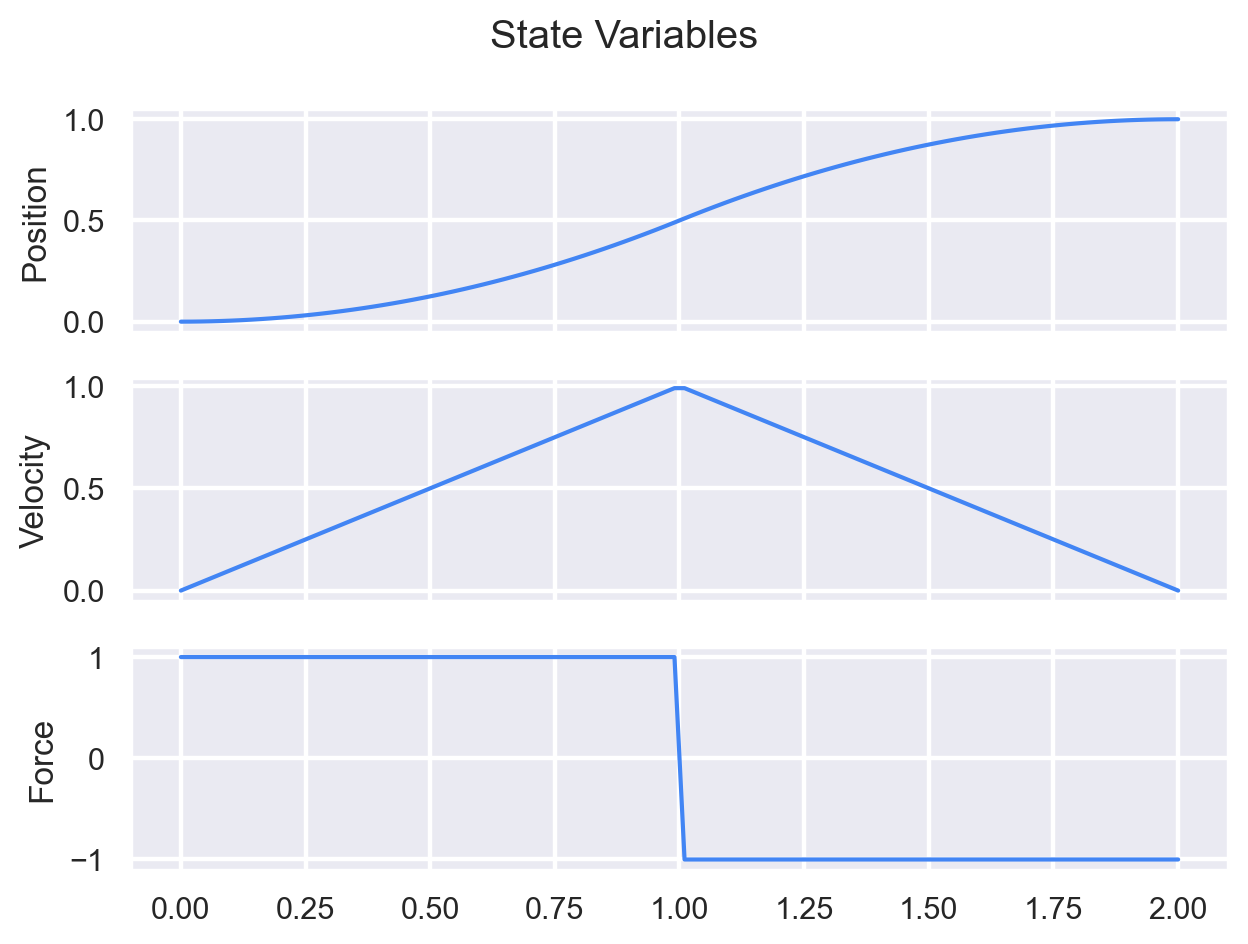

In [5]:
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

fig, ax = plt.subplots(3, sharex=True)
for a, (name, var) in zip(ax, {
    "Position": position,
    "Velocity": velocity,
    "Force"   : force,
}.items()):
    a.plot(sol.value(time), sol.value(var))
    a.set_ylabel(name)
p.show_plot("State Variables")

So, this intuitively makes sense. You should accelerate as fast as you can at the beginning, and then halfway through, start decelerating as much as you can.